In [1]:
## Write ERA5 Waves


import xarray as xr 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

/Users/nicolasdeassisbose/anaconda3/lib/python3.6/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
%cd /Users/nicolasdeassisbose/Desktop/codigo_artigo/era5/

data_era5 = xr.open_dataset('wave_era5_2015_2.nc')

/Users/nicolasdeassisbose/Desktop/codigo_artigo/era5


In [49]:
lat = data_era5['latitude'].values
lon = data_era5['longitude'].values

# Time from ERA5

time_0 = str(time_era5[0])
time_end = str(time_era5[-1])
time = pd.date_range(time_0, time_end, freq='1H')
time_forecast = time.format(formatter=lambda x: x.strftime('%Y%m%d.%H%M'))

29


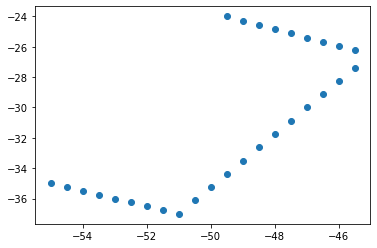

In [9]:
## Function to write the boundary

def coord_points(vert1, vert2, resolution):
    import numpy as np
    
    # Create matrix of linear equation ax + b = y from vertices
    a = np.array([[vert1[0], 1], [vert2[0], 1]])
    b = np.array([vert1[1], vert2[1]])
    
    #Calculate a and b
    a, b = np.linalg.solve(a, b)
    
    # Create list of x coords between vertices
    x_coords = np.arange(vert1[0], vert2[0], resolution).tolist()
    y_coords = []
    
    # Calculate y coords from x coords
    for coord in x_coords:
        y = (a*coord) + b
        y_coords.append(y)
    coords = np.column_stack((x_coords, y_coords))
    return coords


## Grid Coordinate edges

vert_NE = [-45.0, -26.5]
vert_NW = [-49.5, -24.0]
vert_SE = [-51.0, -37.0]
vert_SW = [-55.0, -35.0]

coords_north = coord_points(vert_NW, vert_NE, 0.5)
coords_east = coord_points(vert_SE, vert_NE, 0.5).tolist()
coords_east.sort(reverse = True)
coords_east = np.array(coords_east)
coords_south = coord_points(vert_SW,vert_SE, 0.5).tolist()
coords_south.sort(reverse = True)
coords_south = np.array(coords_south)

coords = np.vstack((coords_north, coords_east, coords_south))

print(len(coords))

plt.scatter(coords[:,[0]],coords[:,[1]])
plt.show()

In [52]:
hs_pr1 = []

for p in range(len(coords)):
    hs_pr01 = data_era5.sel(dict(longitude=(coords[p][0]+360),latitude=coords[p][1]),method='nearest')
    hs_pr1.append(hs_pr01)


Hs = np.array(list(xr.concat(hs_pr1,"new_dim").swh.values))
Tp = np.array(list(xr.concat(hs_pr1,"new_dim").pp1d.values))
Dm = np.array(list(xr.concat(hs_pr1,"new_dim").mwd.values))

## Colum of Directional Spread 
spr = np.ones([len(time_forecast),1])*4 # 4 is used as Directional Spread as suggested in swan manual


In [ ]:
## WRITE TPAR wave boundary condition

for i in range(len(coords)):
    f = open("tpar_era5_" + str(i) + ".bnd", "w")
    f.write("TPAR")
    f.write('''
''')
    TPAR = np.transpose(np.vstack((time_forecast,Hs[i][:],Tp[i][:],Dm[i][:],spr[:,0])))
    f.write(pd.DataFrame(TPAR).to_string(index=False,
                                                   header=False,
                                                   float_format='%10.5f'))
    f = open("tpar_era5_" + str(i) + ".bnd","rt")
    data = f.read()
    data = data.replace(" 2015", "2015")
    
    
    f = open("tpar_era5_" + str(i) + ".bnd","wt")
    f.write(data)
    f.close()
    
    f.close()
    

In [43]:
Hs.shape

(29, 4416)

In [51]:
np.shape(time_forecast)

(4416,)

In [39]:
time_forecast[0]

'20150701.0000'